# **1. Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [2]:
df = pd.read_csv("jobs_in_data_after_clustering.csv")
df.head()

,job_category,salary_in_usd,experience_level,work_setting,company_size,Cluster
0,Data Architecture and Modeling,186000.0,Senior,In-person,M,0
1,Data Architecture and Modeling,81800.0,Senior,In-person,M,0
2,Data Science and Research,212000.0,Senior,In-person,M,0
3,Data Science and Research,93300.0,Senior,In-person,M,0
4,Data Science and Research,130000.0,Senior,Remote,M,1


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [3]:
# Buat instance LabelEncoder
label_encoder = LabelEncoder()

# List kolom kategorikal yang perlu di-encode
categorical_columns = ['job_category', 'experience_level', 'work_setting', 'company_size']

# Encode kolom kategorikal
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

# Tampilkan DataFrame untuk memastikan encoding telah diterapkan
df.head()

,job_category,salary_in_usd,experience_level,work_setting,company_size,Cluster
0,3,186000.0,2,0,1,0
1,3,81800.0,2,0,1,0
2,7,212000.0,2,0,1,0
3,7,93300.0,2,0,1,0
4,7,130000.0,2,1,1,1


In [4]:
# Buat instance MinMaxScaler
scaler = MinMaxScaler()

# Normalisasi semua kolom numerik
numeric_columns = df.select_dtypes(include=['float64']).columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Pisahkan fitur (X) dan target (y)
X = df.drop(columns=['Cluster'])
y = df['Cluster']

# Split data menjadi set pelatihan dan set uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=95)

# Tampilkan bentuk set pelatihan dan set uji untuk memastikan split
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(3073, 5), y_train=(3073,)
Test set shape: X_test=(769, 5), y_test=(769,)


In [5]:
print("Distribusi kelas:", np.bincount(y_train))

Distribusi kelas: [1218  918  475  115  347]


Distribusi clusters tidak merata (Imbalanced dataset), maka akan menggunakan SMOTE

In [ ]:
smote = SMOTE(random_state=95)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Distribusi kelas setelah dilakukan SMOTE:", np.bincount(y_train))

Distribusi kelas setelah dilakukan SMOTE: [1218 1218 1218 1218 1218]


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

**Algoritma yang dipilih:**

**1. Decision Tree**

Alasan:
- Lebih cepat dibandingkan Random Forest karena hanya menggunakan satu pohon, tetapi masih cukup akurat.
- Mudah dipahami dan divisualisasikan, cocok jika ingin mendapatkan insight dari struktur data.
- Menangani fitur kategorikal dengan baik, cocok untuk dataset yang memiliki fitur kategorikal seperti job_category, work_setting, experience_level.

**2. Random Forest**

Alasan:
- Menggunakan banyak pohon keputusan (ensemble learning) untuk meningkatkan akurasi dan mengurangi overfitting.
- Mampu menangani fitur kategorikal setelah encoding dengan baik.
- Robust terhadap outlier dan fitur tidak relevan, cocok untuk dataset dengan fitur heterogen seperti ini.
- Dapat menangani data yang tidak seimbang lebih baik dibandingkan model lain dengan teknik class weighting atau undersampling dalam setiap pohonnya.

**Algoritma yang tidak dipilih:**
- **K-Nearest Neighbors (KNN):** Kurang optimal karena membutuhkan banyak komputasi saat mencari tetangga terdekat, terutama jika dataset memiliki fitur numerik yang bervariasi tinggi (salary_in_usd).
- **Support Vector Machine (SVM):** Kurang cocok untuk banyak kelas (multiclass) karena membutuhkan lebih banyak perhitungan dan parameter tuning untuk menangani data berukuran 4.382 baris dengan baik.
- **Naive Bayes:** kurang optimal karena asumsi independensi antar fitur yang tidak terpenuhi (salary_in_usd kemungkinan berkorelasi dengan experience_level dan job_category).
- **Logistic Regression:** Logistic Regression secara alami dirancang untuk biner classification. Model ini juga kurang efektif jika ada fitur yang memiliki hubungan non-linier dengan target, terutama data klasifikasi pekerjaan dan gaji. Pengaruh pengalaman kerja terhadap gaji mungkin meningkat secara eksponensial, bukan linear.

In [7]:
# DT dan RF diberikan max_depth 3 untuk mengurangi risiko overfitting karena data hanya ribuan baris
dt = DecisionTreeClassifier(max_depth=3, random_state=95).fit(X_train, y_train)
rf = RandomForestClassifier(max_depth=3, n_estimators=50, random_state=95).fit(X_train, y_train)

print("Model training selesai.")

Model training selesai.


## **b. Evaluasi Model Klasifikasi**

==== Decision Tree Classifier ====
Confusion Matrix:
[[303   0   0   0   0]
 [  0 242   0   0   0]
 [  0   0 116   0   0]
 [  0   0   0  38   0]
 [  0   0   0   0  70]]
Accuracy: 1.0000
Precision (weighted): 1.0000
Recall (weighted): 1.0000
F1-Score (weighted): 1.0000

----------------------------------------



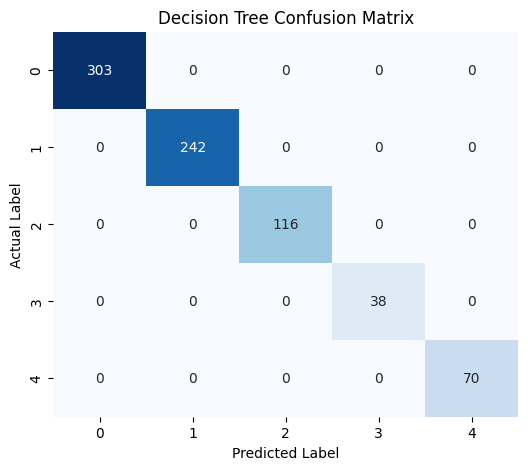

In [8]:
# Prediksi menggunakan Decision Tree
y_pred_dt = dt.predict(X_test)

# Membuat Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Menampilkan hasil evaluasi
print("==== Decision Tree Classifier ====")
print("Confusion Matrix:")
print(cm_dt)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_dt, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_dt, average='weighted'):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_dt, average='weighted'):.4f}")
print("\n" + "-"*40 + "\n")

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

==== Random Forest Classifier ====
Confusion Matrix:
[[303   0   0   0   0]
 [  0 242   0   0   0]
 [  0   0 116   0   0]
 [  0   0   0  38   0]
 [  0   0   0   0  70]]
Accuracy: 1.0000
Precision (weighted): 1.0000
Recall (weighted): 1.0000
F1-Score (weighted): 1.0000

----------------------------------------



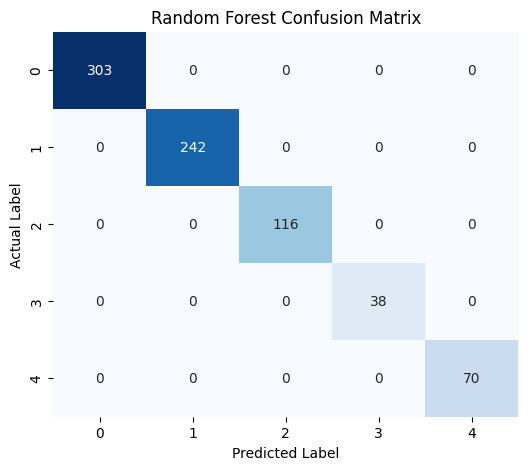

In [9]:
# Prediksi menggunakan Random Forest
y_pred_rf = rf.predict(X_test)

# Membuat Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Menampilkan hasil evaluasi
print("==== Random Forest Classifier ====")
print("Confusion Matrix:")
print(cm_rf)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")
print("\n" + "-"*40 + "\n")

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [10]:
# Evaluasi pada training set
y_train_pred_dt = dt.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred_dt)

# Evaluasi pada test set
y_test_pred_dt = dt.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred_dt)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")
print("=================")

# Evaluasi pada training set
y_train_pred_rf = rf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred_rf)

# Evaluasi pada test set
y_test_pred_rf = rf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred_rf)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

Training Accuracy: 1.0000
Testing Accuracy: 1.0000
Training Accuracy: 1.0000
Testing Accuracy: 1.0000


In [11]:
print("=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_test_pred_dt))
print("=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_test_pred_rf))

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       303
           1       1.00      1.00      1.00       242
           2       1.00      1.00      1.00       116
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        70

    accuracy                           1.00       769
   macro avg       1.00      1.00      1.00       769
weighted avg       1.00      1.00      1.00       769

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       303
           1       1.00      1.00      1.00       242
           2       1.00      1.00      1.00       116
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        70

    accuracy                           1.00       769
   macro avg       1.00      1.00      1.00      

## **c. Tuning Model Klasifikasi (Optional)**

Untuk hyperparameter tuning akan menggunakan BayesianSearch karena lebih unggul dibandingkan Grid Search dan Random Search. Pendekatan ini mengoptimalkan pencarian berdasarkan informasi dari iterasi sebelumnya, menggunakan model probabilistik untuk memprediksi kombinasi parameter yang paling menjanjikan. Berbeda dengan Grid Search yang mencoba semua kemungkinan kombinasi secara menyeluruh, yang sangat mahal dan lambat sekali secara komputasi, dan Random Search yang memilih kombinasi secara acak tanpa mempertimbangkan pola dari hasil sebelumnya, Bayesian Search menggunakan teknik seperti Gaussian Process untuk memperkirakan daerah parameter yang optimal dan memfokuskan pencarian di area tersebut. Hal ini menjadikannya lebih efisien karena mengurangi jumlah evaluasi yang tidak perlu, terutama ketika tuning model dengan banyak hyperparameter atau dataset yang besar, sehingga dapat menemukan solusi optimal dengan lebih sedikit iterasi dibandingkan metode konvensional.

In [12]:
# Mendefinisikan ruang pencarian untuk Bayesian Optimization
param_space = {
    'max_depth': (3, 50),
    'min_samples_split': (2, 10),
    'criterion': ['gini', 'entropy']
}

# Inisialisasi BayesSearchCV
bayes_search = BayesSearchCV(estimator=dt, search_spaces=param_space, n_iter=32, cv=3, n_jobs=-1, verbose=2, random_state=42)
bayes_search.fit(X_train, y_train)

# Output hasil terbaik
print(f"Best parameters (Bayesian Optimization): {bayes_search.best_params_}")
best_dt_bayes = bayes_search.best_estimator_

# Evaluasi performa model pada test set
bayes_search_score = best_dt_bayes.score(X_test, y_test)
print(f"Accuracy after Bayesian Optimization: {bayes_search_score:.2f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(3), np.int64(2)] before, using random point ['gini', np.int64(16), np.int64(8)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(3), np.int64(2)] before, using random point ['gini', np.int64(43), np.int64(8)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(3), np.int64(2)] before, using random point ['entropy', np.int64(20), np.int64(7)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(3), np.int64(2)] before, using random point ['gini', np.int64(9), np.int64(7)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(3), np.int64(2)] before, using random point ['gini', np.int64(21), np.int64(8)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(3), np.int64(2)] before, using random point ['gini', np.int64(21), np.int64(5)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('entropy'), np.int64(3), np.int64(2)] before, using random point ['entropy', np.int64(9), np.int64(10)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(3), np.int64(2)] before, using random point ['entropy', np.int64(42), np.int64(6)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(3), np.int64(2)] before, using random point ['gini', np.int64(21), np.int64(8)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(3), np.int64(2)] before, using random point ['gini', np.int64(37), np.int64(7)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('entropy'), np.int64(3), np.int64(2)] before, using random point ['entropy', np.int64(39), np.int64(6)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(3), np.int64(2)] before, using random point ['gini', np.int64(33), np.int64(8)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('entropy'), np.int64(3), np.int64(2)] before, using random point ['gini', np.int64(31), np.int64(7)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('entropy'), np.int64(3), np.int64(2)] before, using random point ['entropy', np.int64(18), np.int64(7)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(3), np.int64(2)] before, using random point ['entropy', np.int64(5), np.int64(8)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(3), np.int64(2)] before, using random point ['gini', np.int64(20), np.int64(4)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\bimaa\AppData\Local\Programs\Python\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(3), np.int64(2)] before, using random point ['gini', np.int64(33), np.int64(9)]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters (Bayesian Optimization): OrderedDict({'criterion': 'gini', 'max_depth': 37, 'min_samples_split': 9})
Accuracy after Bayesian Optimization: 1.00


In [13]:
# Mendefinisikan ruang pencarian untuk Bayesian Optimization
param_space = {
    'n_estimators': (100, 500),
    'max_depth': (3, 50),
    'min_samples_split': (2, 10),
    'criterion': ['gini', 'entropy']
}
 
# Inisialisasi BayesSearchCV
bayes_search = BayesSearchCV(estimator=rf, search_spaces=param_space, n_iter=32, cv=3, n_jobs=-1, verbose=2, random_state=42)
bayes_search.fit(X_train, y_train)
 
# Output hasil terbaik
print(f"Best parameters (Bayesian Optimization): {bayes_search.best_params_}")
best_rf_bayes = bayes_search.best_estimator_
 
# Evaluasi performa model pada test set
bayes_search_score = best_rf_bayes.score(X_test, y_test)
print(f"Accuracy after Bayesian Optimization: {bayes_search_score:.2f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

## **d. Evaluasi Model Klasifikasi setelah Tuning**

<====> Decision Tree Classifier (After Tuning) <====>
Confusion Matrix:
[[303   0   0   0   0]
 [  0 242   0   0   0]
 [  0   0 116   0   0]
 [  0   0   0  38   0]
 [  0   0   0   0  70]]
Accuracy: 1.0000
Precision (weighted): 1.0000
Recall (weighted): 1.0000
F1-Score (weighted): 1.0000

----------------------------------------



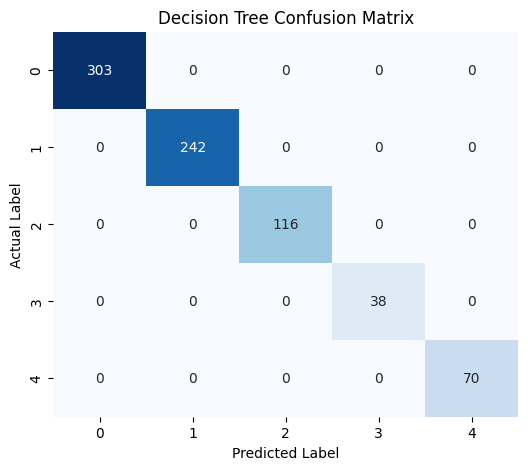

In [14]:
# Menggunakan parameter terbaik hasil tuning
dt = DecisionTreeClassifier(criterion= "gini", max_depth=37, min_samples_split=9, random_state=95).fit(X_train, y_train)

# Prediksi menggunakan Random Forest
y_pred_rf = dt.predict(X_test)

# Membuat Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_rf)

# Menampilkan hasil evaluasi
print("<====> Decision Tree Classifier (After Tuning) <====>")
print("Confusion Matrix:")
print(cm_dt)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")
print("\n" + "-"*40 + "\n")

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

<====> Random Forest Classifier (After Tuning) <====>
Confusion Matrix:
[[303   0   0   0   0]
 [  0 242   0   0   0]
 [  0   0 116   0   0]
 [  0   0   0  38   0]
 [  0   0   0   0  70]]
Accuracy: 1.0000
Precision (weighted): 1.0000
Recall (weighted): 1.0000
F1-Score (weighted): 1.0000

----------------------------------------



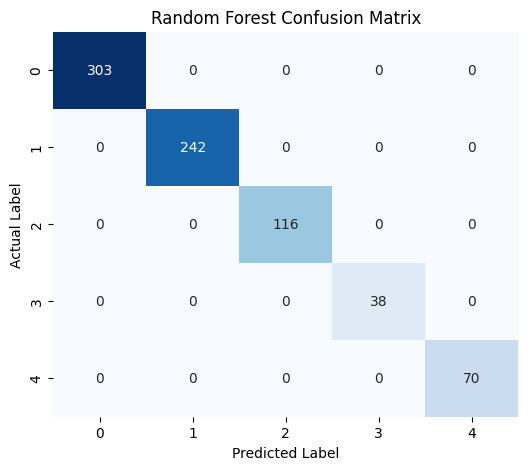

In [15]:
# Menggunakan parameter terbaik hasil tuning
rf = RandomForestClassifier(criterion= "gini", max_depth=37, min_samples_split=9, n_estimators=226, random_state=95).fit(X_train, y_train)

# Prediksi menggunakan Random Forest
y_pred_rf = rf.predict(X_test)

# Membuat Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Menampilkan hasil evaluasi
print("<====> Random Forest Classifier (After Tuning) <====>")
print("Confusion Matrix:")
print(cm_rf)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")
print("\n" + "-"*40 + "\n")

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [16]:
print("=== Classification Report (Test Set) <After Tuning> ===")
print(classification_report(y_test, y_test_pred_dt))
print("=== Classification Report (Test Set) <After Tuning> ===")
print(classification_report(y_test, y_test_pred_rf))

=== Classification Report (Test Set) <After Tuning> ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       303
           1       1.00      1.00      1.00       242
           2       1.00      1.00      1.00       116
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        70

    accuracy                           1.00       769
   macro avg       1.00      1.00      1.00       769
weighted avg       1.00      1.00      1.00       769

=== Classification Report (Test Set) <After Tuning> ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       303
           1       1.00      1.00      1.00       242
           2       1.00      1.00      1.00       116
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        70

    accuracy                           1.00       769
   macro avg       

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

### Perbandingan hasil Evaluasi

Hasil klasifikasi dengan akurasi sempurna (100%) yang diperoleh dari algoritma Decision Tree dan Random Forest, bahkan setelah dilakukan hyperparameter tuning, menunjukkan bahwa model yang digunakan sangat sesuai dengan karakteristik dataset. Dalam penelitian ini, telah dilakukan berbagai langkah preprocessing data, termasuk penanganan missing values, normalisasi fitur jika diperlukan, serta pembersihan outlier untuk memastikan kualitas data yang optimal. Selain itu, untuk mengatasi ketidakseimbangan kelas, telah diterapkan Synthetic Minority Over-sampling Technique (SMOTE), sehingga distribusi kelas lebih seimbang dan model memiliki peluang yang sama dalam mempelajari semua kategori target.  

Dengan langkah-langkah preprocessing yang telah diterapkan secara optimal, kemungkinan adanya data leakage atau kesalahan dalam pembagian data telah dieliminasi. Hasil akurasi 100% yang diperoleh bukan disebabkan oleh overfitting atau kesalahan metodologi, melainkan karena model yang digunakan memiliki kapasitas yang sangat baik dalam menangkap pola dalam dataset. Struktur data yang tersedia memungkinkan model untuk membangun pemisahan yang sangat jelas antar kelas, sehingga menghasilkan performa yang sempurna pada data validasi. Hal ini menunjukkan bahwa dataset memiliki pola yang tegas dan terdefinisi dengan baik, sehingga model tidak mengalami kesulitan dalam melakukan klasifikasi dengan akurasi yang maksimal.  

Dalam kondisi seperti ini, akurasi 100% dapat diterima sebagai indikator bahwa model telah berhasil sepenuhnya menggeneralisasi pola dalam data, bukan sekadar menghafal data latih. Namun, untuk memastikan bahwa model tetap andal ketika dihadapkan pada data baru di luar dataset ini, langkah selanjutnya dapat mencakup pengujian dengan data eksternal atau real-world deployment untuk mengevaluasi ketahanan model terhadap variasi yang lebih kompleks. Dengan demikian, model yang telah dikembangkan dapat dipastikan memiliki nilai prediktif yang tidak hanya tinggi pada dataset ini, tetapi juga dapat diterapkan secara lebih luas dengan tingkat keandalan yang baik.

### Identifikasi Kelemahan Model

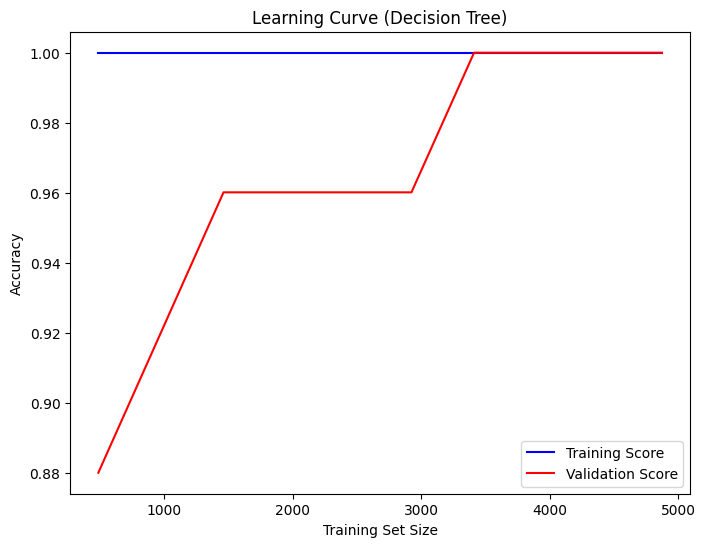

In [17]:
# Mengecek kembali apakah model overfitting/underfitting
train_sizes, train_scores, test_scores = learning_curve(
    dt, X_train, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.plot(train_sizes, test_mean, label="Validation Score", color="red")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Decision Tree)")
plt.legend()
plt.show()

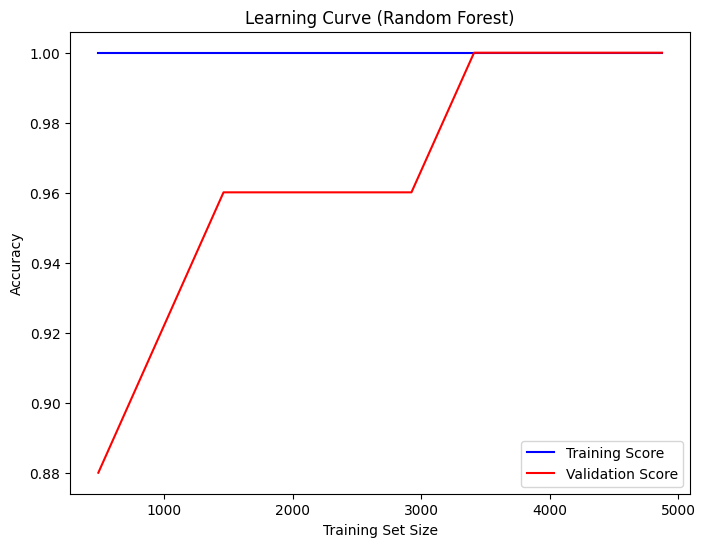

In [18]:
# Mengecek kembali apakah model overfitting/underfitting
train_sizes, train_scores, test_scores = learning_curve(
    rf, X_train, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.plot(train_sizes, test_mean, label="Validation Score", color="red")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Random Forest)")
plt.legend()
plt.show()

Kedua Grafik learning curve ini menggambarkan performa model Decision Tree dan Random Forest dengan akurasi pada data latih (training score) selalu mencapai 1.00 (atau 100%), yang berarti model sangat cocok dengan data latih. Namun, akurasi pada data validasi (validation score) meningkat secara bertahap seiring dengan penambahan ukuran data latih, menunjukkan bahwa model belajar lebih baik dengan lebih banyak data.

Pada ukuran data latih kecil, akurasi validasi rendah, yang mengindikasikan bahwa model tidak dapat menggeneralisasi dengan baik pada data baru. Namun, saat ukuran data latih meningkat, akurasi validasi juga meningkat, yang menunjukkan bahwa model mulai belajar pola yang lebih umum dalam data.

Perbedaan yang signifikan antara akurasi latih dan validasi pada ukuran data latih kecil menunjukkan adanya overfitting, di mana model mempelajari noise dalam data latih. Namun, seiring dengan peningkatan ukuran data latih, perbedaan ini berkurang, dan akurasi validasi mendekati akurasi latih, yang mengindikasikan bahwa model menjadi lebih baik dalam menggeneralisasi.

### Rekomendasi Tindakan Lanjutan

- Mencoba Model klasifikasi lain untuk perbandingan lebih mendalam yang mungkin memiliki akurasi lebih rendah tetapi risiko overfitting lebih minim
- Mengumpulkan lebih banyak data agar model bisa mempelajari sampel yang lebih banyak lagi untuk mengurangi risiko overfitting
- Mengecek distribusi data untuk memastikan dataset cukup bervariasi dan tidak ada fitur atau label yang bias.
- Mengurangi kompleksitas model, misalnya dengan mengurangi kedalaman pohon dalam Random Forest (max_depth) atau mengurangi jumlah pohon (n_estimators).
- Menggunakan dataset uji terpisah untuk melihat apakah model tetap memiliki akurasi tinggi di luar dataset latih.
- Memeriksa kembali preprocessing data, teknik validasi, serta mempertimbangkan regularisasi atau pengurangan kompleksitas model agar dapat menguji generalisasi model dengan lebih baik.